# Download Data

In [1]:
 !pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download carrie1/ecommerce-data

Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown


In [5]:
!unzip /content/ecommerce-data.zip

Archive:  /content/ecommerce-data.zip
  inflating: data.csv                


# Explore and Preprocess

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/raw.csv', encoding = "ISO-8859-1", dtype={'CustomerID': str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [ ]:
# !pip install ydata-profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: multimethod
    Found existing installation: multimethod 2.0
    Uninstalling multimethod-2.0:
      Successfully uninstalled multimethod-2.0
  Attempting uninstall: imagehash
    Found existing installation: ImageHash 4.3.2
    Uninstalling ImageHash-4.3.2:
      Successfully uninstalled ImageHash-4.3.2
  Attempting uninstall: visions
    Found existing installation: visions 0.7.4
    Uninstalling visions-0.7.4:
      Successfully uninstalled visions-0.7.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.

In [ ]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Profiling Report")
# profile.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
def preprocessing(df: pd.DataFrame):
  df = df.copy()

  df.dropna(inplace=True, subset=['CustomerID', 'Description'])
  df.drop_duplicates(inplace=True)

  # drop cancelled invoice in InvoiceNo
  df = df[~df['InvoiceNo'].str.startswith('C')]

  # format datetime type
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

  return df

In [4]:
a = preprocessing(df)
a.shape

(392732, 8)

In [5]:
def revenue_by_day(df: pd.DataFrame):
  df = df.copy()

  # group by Date, calculate sum of total price and keep time features such as weekday, month, ...
  df = df.groupby(['Date', 'Year', 'Quarter', 'Month', 'Weekday', 'DayOfYear']).agg({'TotalPrice': 'sum'}).reset_index()

  return df

In [6]:
def feature_engineer(df: pd.DataFrame):
    df = df.copy()

    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    df['Date'] = df['InvoiceDate'].dt.date
    df['Year'] = df['InvoiceDate'].dt.year
    df['Quarter'] = df['InvoiceDate'].dt.quarter
    df['Month'] = df['InvoiceDate'].dt.month
    df['Weekday'] = df['InvoiceDate'].dt.weekday
    df['DayOfYear'] = df['InvoiceDate'].dt.dayofyear

    # drop InvoiceDate
    df.drop(columns=['InvoiceDate'], inplace=True)

    # filter
    lower_bound = df['TotalPrice'].quantile(0.01)
    upper_bound = df['TotalPrice'].quantile(0.99)
    df = df[(df['TotalPrice'] >= lower_bound) & (df['TotalPrice'] <= upper_bound)]

    # group
    df = revenue_by_day(df)

    return df

In [7]:
a = preprocessing(df)
a = feature_engineer(a)
a.head()

,Date,Year,Quarter,Month,Weekday,DayOfYear,TotalPrice
0,2010-12-01,2010,4,12,2,335,35376.36
1,2010-12-02,2010,4,12,3,336,35914.33
2,2010-12-03,2010,4,12,4,337,19312.81
3,2010-12-05,2010,4,12,6,339,28513.18
4,2010-12-06,2010,4,12,0,340,26574.17


In [25]:
a.describe()

,Year,Quarter,Month,Weekday,DayOfYear,TotalPrice
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,2010.934426,2.534426,6.636066,2.678689,185.770492,22036.169213
std,0.247942,1.126663,3.465337,1.947089,105.030414,9794.438586
min,2010.000000,1.000000,1.000000,0.000000,4.000000,3439.100000
25%,2011.000000,2.000000,4.000000,1.000000,93.000000,15742.850000
50%,2011.000000,3.000000,7.000000,3.000000,188.000000,20024.800000
75%,2011.000000,4.000000,10.000000,4.000000,278.000000,27584.300000
max,2011.000000,4.000000,12.000000,6.000000,357.000000,57240.970000


In [ ]:
# tìm ngày gần nhất và xa nhất
print(a['Date'].min())
print(a['Date'].max())

# tính số ngày trong khoảng đó
print((a['Date'].max() - a['Date'].min()).days)

2010-12-01
2011-12-09
373


In [8]:
# tạo dữ liệu những ngày thiếu
a = a.set_index('Date')
a = a.asfreq('D')
a = a.reset_index()
a.head()

,Date,Year,Quarter,Month,Weekday,DayOfYear,TotalPrice
0,2010-12-01,2010.0,4.0,12.0,2.0,335.0,35376.36
1,2010-12-02,2010.0,4.0,12.0,3.0,336.0,35914.33
2,2010-12-03,2010.0,4.0,12.0,4.0,337.0,19312.81
3,2010-12-04,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-12-05,2010.0,4.0,12.0,6.0,339.0,28513.18


In [9]:
def rebuild_time_features(df):
    df = df.copy()
    df['Year'] = df['Date'].dt.year
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Weekday'] = df['Date'].dt.weekday
    df['DayOfYear'] = df['Date'].dt.dayofyear
    return df


In [10]:
a = rebuild_time_features(a)
a['TotalPrice'] = a['TotalPrice'].fillna(a['TotalPrice'].interpolate())
a.head()

,Date,Year,Quarter,Month,Weekday,DayOfYear,TotalPrice
0,2010-12-01,2010,4,12,2,335,35376.360
1,2010-12-02,2010,4,12,3,336,35914.330
2,2010-12-03,2010,4,12,4,337,19312.810
3,2010-12-04,2010,4,12,5,338,23912.995
4,2010-12-05,2010,4,12,6,339,28513.180


In [11]:
def time_series_feature(df: pd.DataFrame):
  df = df.copy()

  # rolling mean and rolling std window=3
  df['TotalPrice_rolling_mean3'] = df['TotalPrice'].rolling(window=3).mean()
  df['TotalPrice_rolling_std3'] = df['TotalPrice'].rolling(window=3).std()

  # bfil na
  df['TotalPrice_rolling_mean3'] = df['TotalPrice_rolling_mean3'].fillna(method='bfill')
  df['TotalPrice_rolling_std3'] = df['TotalPrice_rolling_std3'].fillna(method='bfill')

  return df

In [12]:
a = time_series_feature(a)
a.head()

C:\Users\Ngoc\AppData\Local\Temp\ipykernel_20272\2248821184.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['TotalPrice_rolling_mean3'] = df['TotalPrice_rolling_mean3'].fillna(method='bfill')
C:\Users\Ngoc\AppData\Local\Temp\ipykernel_20272\2248821184.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['TotalPrice_rolling_std3'] = df['TotalPrice_rolling_std3'].fillna(method='bfill')


,Date,Year,Quarter,Month,Weekday,DayOfYear,TotalPrice,TotalPrice_rolling_mean3,TotalPrice_rolling_std3
0,2010-12-01,2010,4,12,2,335,35376.360,30201.166667,9433.429181
1,2010-12-02,2010,4,12,3,336,35914.330,30201.166667,9433.429181
2,2010-12-03,2010,4,12,4,337,19312.810,30201.166667,9433.429181
3,2010-12-04,2010,4,12,5,338,23912.995,26380.045000,8571.310772
4,2010-12-05,2010,4,12,6,339,28513.180,23912.995000,4600.185000


In [13]:
# save data
a.to_csv('data/clean_by_day.csv', index=False)

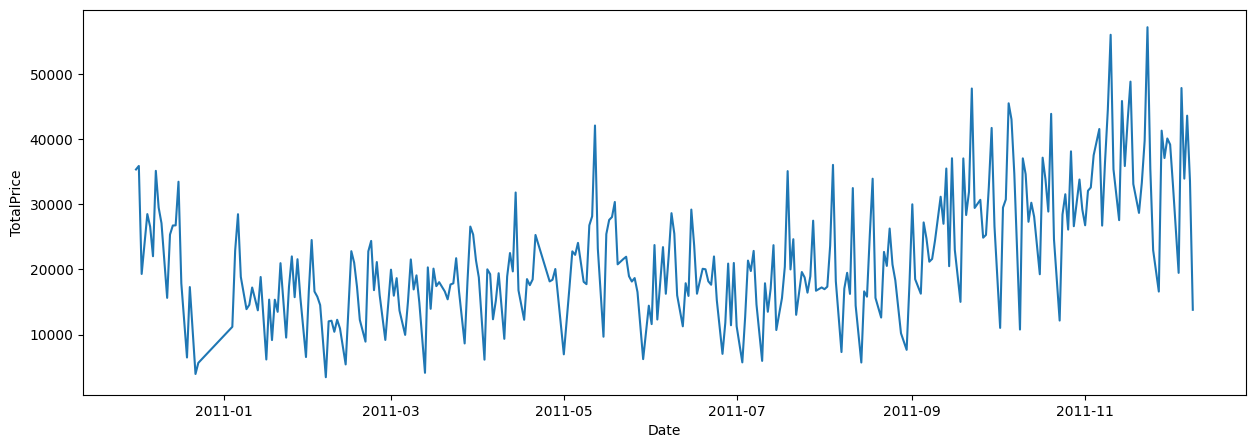

In [14]:
# plot TotalPrice with Date
plt.figure(figsize=(15, 5))
sns.lineplot(data=a, x='Date', y='TotalPrice')
plt.show()

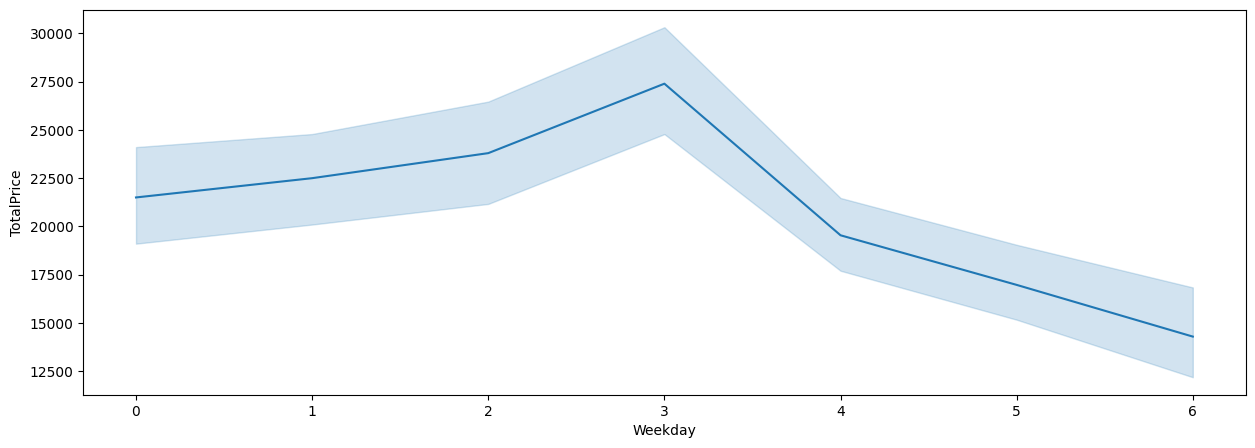

In [ ]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=a, x='Weekday', y='TotalPrice')
plt.show()

In [34]:
# train test split
train_size = int(len(a) * 0.8)
train, test = a[:train_size], a[train_size:]

In [35]:
# test ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['TotalPrice'], order=(5, 1, 1),
              exog=train[['Weekday', 'Month', 'DayOfYear', 'TotalPrice_rolling_mean3', 'TotalPrice_rolling_std3']])
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             TotalPrice   No. Observations:                  299
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -2868.176
Date:                Mon, 05 May 2025   AIC                           5760.353
Time:                        07:53:35   BIC                           5804.718
Sample:                             0   HQIC                          5778.112
                                - 299                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Weekday                   -916.2826    202.376     -4.528      0.000   -1312.932    -519.633
Month                     -419.9788    720.897     -0.583      0.560   -1832.911     992.

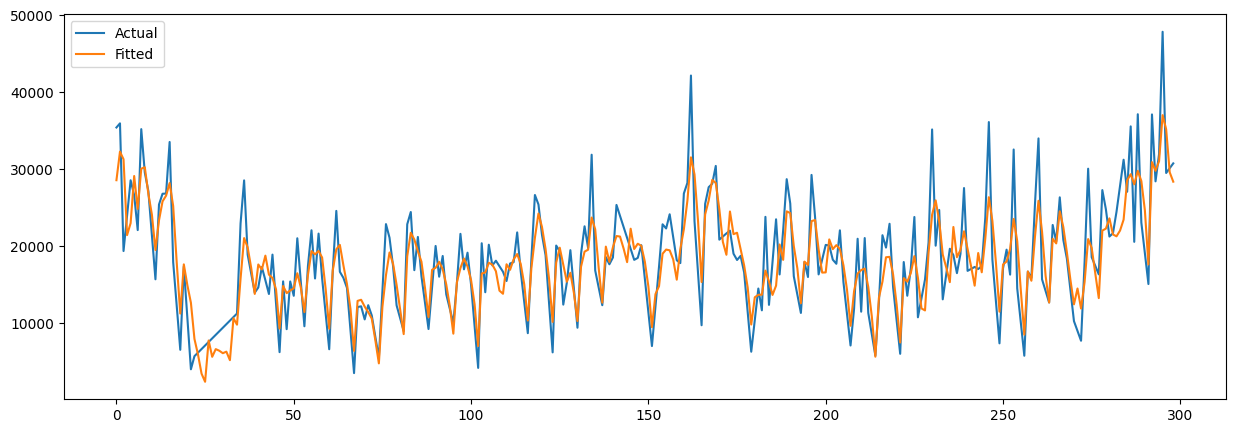

In [36]:
# predict cho train
fitted_values = model_fit.fittedvalues

# plot
plt.figure(figsize=(15, 5))
plt.plot(train['TotalPrice'], label='Actual')
plt.plot(fitted_values, label='Fitted')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(train['TotalPrice'], fitted_values)
mape = mean_absolute_percentage_error(train['TotalPrice'], fitted_values)

print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MAE: 2869.9310090028616
MAPE: 0.18283588506502882


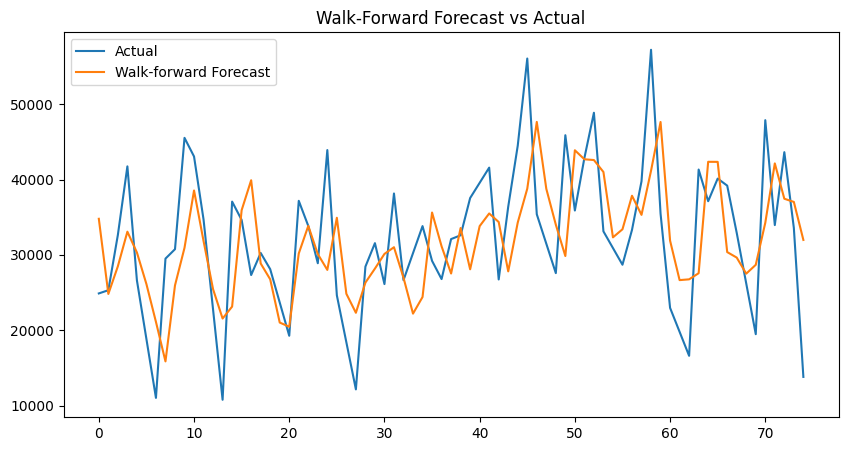

In [ ]:
# test walk forecast
history = list(train['TotalPrice'])
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(7, 1, 1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]  # giá trị dự báo tiếp theo
    predictions.append(yhat)
    history.append(test['TotalPrice'].iloc[t])  # thêm giá trị thực tế vào lịch sử

plt.figure(figsize=(10,5))
plt.plot(test['TotalPrice'].values, label='Actual')
plt.plot(predictions, label='Walk-forward Forecast')
plt.legend()
plt.title('Walk-Forward Forecast vs Actual')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(test['TotalPrice'], predictions)
mape = mean_absolute_percentage_error(test['TotalPrice'], predictions)

print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MAE: 7021.233527794797
MAPE: 0.24885331030719063


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

MAPE: 0.1755
MAE: 4782.80


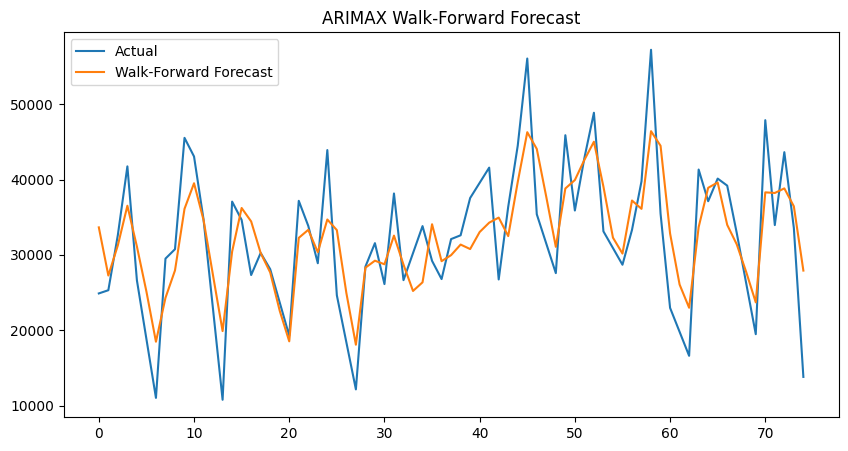

In [38]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Reset index để dễ truy cập
external_features = a[['Weekday', 'Month','DayOfYear','TotalPrice_rolling_mean3', 'TotalPrice_rolling_std3']]
external_train = external_features[:len(train)]
external_test = external_features[len(train):].reset_index(drop=True)

# Khởi tạo
history_y = list(train['TotalPrice'])
predictions = []

# Walk-forward forecast
for t in range(len(test)):
    # Fit mô hình ARIMAX
    model = ARIMA(history_y, order=(7, 1, 1), exog=external_train[:len(history_y)])
    model_fit = model.fit()

    # Dự báo 1 bước tiếp theo
    exog_input = external_test.iloc[t:t+1]  # Lấy đúng 1 hàng với 2 cột
    yhat = model_fit.forecast(exog=exog_input.values).iloc[0]
    predictions.append(yhat)

    # Cập nhật lịch sử
    history_y.append(test['TotalPrice'].iloc[t])
    external_train = external_features[:len(train) + t + 1]

# Đánh giá
mape = mean_absolute_percentage_error(test['TotalPrice'], predictions)
mae = mean_absolute_error(test['TotalPrice'], predictions)
print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.2f}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(test['TotalPrice'].values, label='Actual')
plt.plot(predictions, label='Walk-Forward Forecast')
plt.legend()
plt.title('ARIMAX Walk-Forward Forecast')
plt.show()
